In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, BatchNormalization, Activation, Dense, Dropout, 
                                    Lambda, RepeatVector, Reshape, Conv2D, Conv2DTranspose,
                                    MaxPooling2D, GlobalMaxPool2D, concatenate, add, multiply,
                                    AveragePooling2D, UpSampling2D, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [2]:
# Configuration
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 1
EPOCHS = 30
INIT_LR = 1e-3
kinit = 'he_normal'


In [3]:
# ==================== LOSS FUNCTIONS ====================
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
    return tn


def prec(y_true, y_pred):
    prec, _ = confusion(y_true, y_pred)
    return prec

def recall(y_true, y_pred):
    _, recall_val = confusion(y_true, y_pred)
    return recall_val

In [4]:
# ==================== DATA LOADER ====================
def get_data(path, train=True):
    """Load and preprocess images and masks"""
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    
    if train:
        y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    
    print('Getting and resizing images...')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + 'images/' + id_, color_mode='rgb')
        x_img = img_to_array(img)
        x_img = tf.image.resize(x_img, (IMG_HEIGHT, IMG_WIDTH))
        x_img = x_img.numpy()  # Convert tensor to numpy array

        # Normalize and store image (all 3 channels)
        X[n] = x_img / 255.0  # Store all channels

        # Handle different file extensions for masks
        fname, extension = os.path.splitext(id_)
        mask_id_ = fname + '.png' if extension != '.png' else id_

        # Load masks if training
        if train:
            mask = load_img(path + 'masks/' + mask_id_, color_mode='grayscale')
            mask = img_to_array(mask)
            mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
            mask = mask.numpy()
            y[n] = mask / 255.0  # Normalize mask
    
    print('Done!')
    return (X, y) if train else X


In [5]:
# ==================== MODEL ARCHITECTURE ====================
def AttnGatingBlock(x, g, inter_shape, name):
    """Attention Gating Block"""
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                               strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                               padding='same', name='g_up'+name)(phi_g)

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = Lambda(lambda x: K.repeat_elements(x, shape_x[3], axis=3), name='psi_up'+name)(upsample_psi)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same', name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetGatingSignal(input, is_batchnorm, name):
    """Gating signal for attention"""
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same", name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name=name + '_act')(x)
    return x

def UnetConv2D(input, outdim, is_batchnorm, name):
    """Basic U-Net convolution block"""
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x

def ASPP(input, out_channel, name):
    """Atrous Spatial Pyramid Pooling module"""
    # Branch 1: 1x1 convolution
    x1 = Conv2D(out_channel, (1, 1), kernel_initializer=kinit, padding="same", dilation_rate=1, name=name+'_conv1')(input)
    x1 = BatchNormalization(name=name+'_bn1')(x1)
    x1 = Activation('relu', name=name+'_act1')(x1)

    # Branch 2: 3x3 dilation rate 6
    x2 = Conv2D(out_channel, (3, 3), kernel_initializer=kinit, padding="same", dilation_rate=6, name=name+'_conv2')(input)
    x2 = BatchNormalization(name=name+'_bn2')(x2)
    x2 = Activation('relu', name=name+'_act2')(x2)

    # Branch 3: 3x3 dilation rate 12
    x3 = Conv2D(out_channel, (3, 3), kernel_initializer=kinit, padding="same", dilation_rate=12, name=name+'_conv3')(input)
    x3 = BatchNormalization(name=name+'_bn3')(x3)
    x3 = Activation('relu', name=name+'_act3')(x3)

    # Branch 4: 3x3 dilation rate 18
    x4 = Conv2D(out_channel, (3, 3), kernel_initializer=kinit, padding="same", dilation_rate=18, name=name+'_conv4')(input)
    x4 = BatchNormalization(name=name+'_bn4')(x4)
    x4 = Activation('relu', name=name+'_act4')(x4)

    # Branch 5: Global Average Pooling
    x5 = AveragePooling2D(pool_size=(1, 1))(input)
    x5 = Conv2D(out_channel, (1, 1), kernel_initializer=kinit, padding="same", name=name+'_conv5')(x5)
    x5 = BatchNormalization(name=name+'_bn5')(x5)
    x5 = Activation('relu', name=name+'_act5')(x5)
    x5 = UpSampling2D(size=(K.int_shape(input)[1]//K.int_shape(x5)[1], 
                          K.int_shape(input)[2]//K.int_shape(x5)[2]))(x5)

    # Concatenate all branches
    x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
    x = Conv2D(out_channel, (1, 1), kernel_initializer=kinit, padding="same", name=name+'_conv_final')(x)
    x = BatchNormalization(name=name+'_bn_final')(x)
    x = Activation('relu', name=name+'_act_final')(x)
    x = Dropout(0.5)(x)

    return x

def build_attn_unet(input_size, loss_function):
    """Build the complete Attention U-Net with ASPP"""
    inputs = Input(shape=input_size)
    
    # Encoder
    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    conv1 = Dropout(0.2, name='drop_conv1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = UnetConv2D(pool1, 32, is_batchnorm=True, name='conv2')
    conv2 = Dropout(0.2, name='drop_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 64, is_batchnorm=True, name='conv3')
    conv3 = Dropout(0.2, name='drop_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 64, is_batchnorm=True, name='conv4')
    conv4 = Dropout(0.2, name='drop_conv4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Center with ASPP
    center = ASPP(pool4, 128, name='center')
    
    # Decoder with Attention Gates
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', 
                                     activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', 
                                     activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up2, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', 
                                     activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', 
                                     activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')
    
    # Output layer
    out = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=kinit, name='final')(up4)
    
    model = Model(inputs=[inputs], outputs=[out])
    return model


In [6]:
# ==================== TRAINING SETUP ====================
def setup_training():
    """Setup and compile the model"""
    input_size = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    
    # Build model
    model = build_attn_unet(input_size, dice_loss)
    
    # Compile model
    optimizer = Adam(learning_rate=INIT_LR)
    model.compile(optimizer=optimizer, loss=dice_loss, 
                 metrics=[dsc, tp, tn, prec, recall])
    
    return model

regular model training:

In [7]:
# ==================== TRAINING BLOCK ====================
print("=== TRAINING PHASE ===")

# Load TRAINING data
print("Loading training data...")
path_train = 'training_dataset/tithe/'
X_train, y_train = get_data(path_train, train=True)

# After loading X_train, y_train
print("Filtering out empty masks...")
non_empty_indices = [i for i in range(len(y_train)) if not np.all(y_train[i] == 0)]
X_train_filtered = X_train[non_empty_indices]
y_train_filtered = y_train[non_empty_indices]

print(f"Filtered training samples: {X_train_filtered.shape[0]}")
# Use X_train_filtered and y_train_filtered for train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_filtered, y_train_filtered, test_size=0.3, random_state=42
)

# Split data (train/validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_valid.shape[0]}")

# Setup model
print("Building model...")
model = setup_training()
model.summary()

# Callbacks
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model-T_u-a_d_aspp-maproad.h5', verbose=1, 
                   save_best_only=True, save_weights_only=True),
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
]

# Train model
print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid),
    verbose=1
)

# Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Clear memory - CRITICAL STEP
del X_train, y_train, X_valid, y_valid
tf.keras.backend.clear_session()
print("Training completed! Memory cleared.")

=== TRAINING PHASE ===
Loading training data...
Getting and resizing images...


  0%|          | 0/1260 [00:00<?, ?it/s]

100%|██████████| 1260/1260 [00:11<00:00, 108.75it/s]


Done!
Filtering out empty masks...
Filtered training samples: 537
Training samples: 262
Validation samples: 113
Building model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_1_bn (BatchNormalization  (None, 256, 256, 32  128      

***
Debugging:

***

In [9]:
# ==================== EVALUATION BLOCK ====================
print("=== EVALUATION PHASE ===")

# Load the saved model
print("Loading trained model...")
model = build_attn_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dice_loss)
model.load_weights('model-T_u-a_d_aspp-maproad.h5')

# Recompile with metrics
optimizer = Adam(learning_rate=INIT_LR)
model.compile(optimizer=optimizer, loss=dice_loss, 
             metrics=[dsc, tp, tn, prec, recall])

# Load TEST data
print("Loading test data...")
path_test = 'training_dataset/tithe/test/'
X_test, y_test = get_data(path_test, train=True)

# Evaluate model
print("Evaluating model...")
test_loss, test_dsc, test_tp, test_tn, test_prec, test_recall = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1
)

print(f"Test Results:")
print(f"Dice Score: {test_dsc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"True Positive Rate: {test_tp:.4f}")
print(f"True Negative Rate: {test_tn:.4f}")

# Clear memory
del X_test, y_test
tf.keras.backend.clear_session()
print("Evaluation completed! Memory cleared.")

=== EVALUATION PHASE ===
Loading trained model...
Loading test data...
Getting and resizing images...


100%|██████████| 42/42 [00:00<00:00, 104.96it/s]


Done!
Evaluating model...
42/42 [==============================] - 2s 17ms/step - loss: 0.4068 - dsc: 0.5932 - tp: 0.8911 - tn: 0.9966 - prec: 0.5537 - recall: 0.8905
Test Results:
Dice Score: 0.5932
Precision: 0.5537
Recall: 0.8905
True Positive Rate: 0.8911
True Negative Rate: 0.9966
Evaluation completed! Memory cleared.


In [10]:
# ==================== PREDICTION BLOCK ====================
print("=== PREDICTION PHASE ===")

# Load the saved model
print("Loading trained model...")
model = build_attn_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dice_loss)
model.load_weights('model-T_u-a_d_aspp-maproad.h5')

# Load data in smaller chunks for prediction
def predict_in_chunks(data_path, output_name, chunk_size=50):
    """Predict on data in manageable chunks"""
    all_predictions = []
    
    # Get all files
    image_dir = os.path.join(data_path, "images")
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    
    for i in range(0, len(image_files), chunk_size):
        print(f"Processing chunk {i//chunk_size + 1}/{(len(image_files)-1)//chunk_size + 1}")
        
        # Load chunk of data
        chunk_files = image_files[i:i+chunk_size]
        X_chunk = np.zeros((len(chunk_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
        
        for j, fname in enumerate(chunk_files):
            img_path = os.path.join(image_dir, fname)
            img = load_img(img_path, color_mode='rgb')
            x_img = img_to_array(img)
            x_img = tf.image.resize(x_img, (IMG_HEIGHT, IMG_WIDTH))
            x_img = x_img.numpy()
            X_chunk[j] = x_img / 255.0
        
        # Predict on chunk
        preds_chunk = model.predict(X_chunk, batch_size=2, verbose=0)
        all_predictions.append(preds_chunk)
        
        # Clear memory
        del X_chunk
        tf.keras.backend.clear_session()

    # Combine all predictions
    predictions = np.vstack(all_predictions)

    # save results
    np.save(f'{output_name}.npy', predictions)
    print(f"Predictions saved to {output_name}.npy")

    return predictions

# Make predictions in chunks
print("Making predictions on training data...")
preds_train = predict_in_chunks('training_dataset/tithe/', 'train_predictions')
np.save('train_predictions.npy', preds_train)
del preds_train

print("Making predictions on validation data...")
preds_val = predict_in_chunks('training_dataset/tithe/', 'val_predictions')
np.save('val_predictions.npy', preds_val)
del preds_val

print("Making predictions on test data...")
preds_test = predict_in_chunks('training_dataset/tithe/test/', 'test_predictions')
np.save('test_predictions.npy', preds_test)
del preds_test

print("All predictions completed and saved!")

=== PREDICTION PHASE ===
Loading trained model...
Making predictions on training data...
Processing chunk 1/26
Processing chunk 2/26
Processing chunk 3/26
Processing chunk 4/26
Processing chunk 5/26
Processing chunk 6/26
Processing chunk 7/26
Processing chunk 8/26
Processing chunk 9/26
Processing chunk 10/26
Processing chunk 11/26
Processing chunk 12/26
Processing chunk 13/26
Processing chunk 14/26
Processing chunk 15/26
Processing chunk 16/26
Processing chunk 17/26
Processing chunk 18/26
Processing chunk 19/26
Processing chunk 20/26
Processing chunk 21/26
Processing chunk 22/26
Processing chunk 23/26
Processing chunk 24/26
Processing chunk 25/26
Processing chunk 26/26
Predictions saved to train_predictions.npy
Making predictions on validation data...
Processing chunk 1/26
Processing chunk 2/26
Processing chunk 3/26
Processing chunk 4/26
Processing chunk 5/26
Processing chunk 6/26
Processing chunk 7/26
Processing chunk 8/26
Processing chunk 9/26
Processing chunk 10/26
Processing chunk 

=== PLOTTING PHASE ===


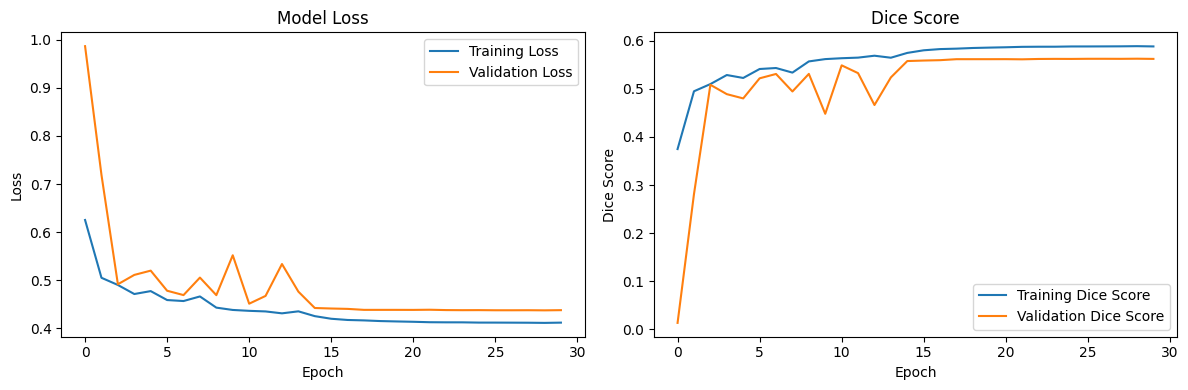

Plotting completed!


In [10]:
# ==================== PLOTTING BLOCK ====================
print("=== PLOTTING PHASE ===")

# Load training history
import pickle
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['dsc'], label='Training Dice Score')
plt.plot(history['val_dsc'], label='Validation Dice Score')
plt.title('Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("Plotting completed!")

In [ ]:
# ==================== PREDICTION FUNCTION ====================

image_path

def predict_on_new_image(image_path, model_path='model-T_u-a_d_aspp-maproad.h5'):
    """Predict on a new image"""
    # Load model
    model = build_attn_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dice_loss)
    model.load_weights(model_path)
    
    # Load and preprocess image
    img = load_img(image_path, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = tf.image.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
    img_array = img_array.numpy() / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    prediction = model.predict(img_array)[0]
    prediction_binary = (prediction > 0.5).astype(np.uint8)
    
    return prediction, prediction_binary

# Example usage for prediction:
# prediction, binary_mask = predict_on_new_image('path_to_your_image.jpg')

earlier, you gave me a code block for prediction which looks like this: ``` ```. Is this what I can use for deploying the model on new images to make intended masks for them? <br>
***
New prediction and visualisation block:

Loading trained model...
Loading image: training_dataset/tithe/test/images/patch_18_21.png
Making prediction...
1/1 [==============================] - 0s 450ms/step


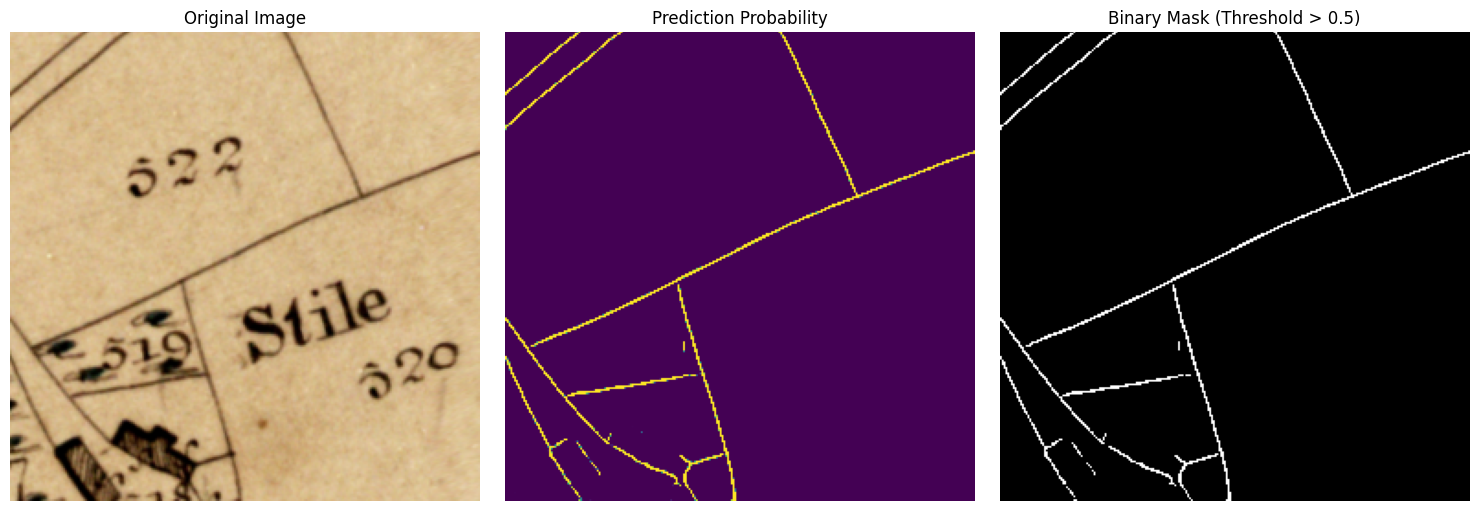

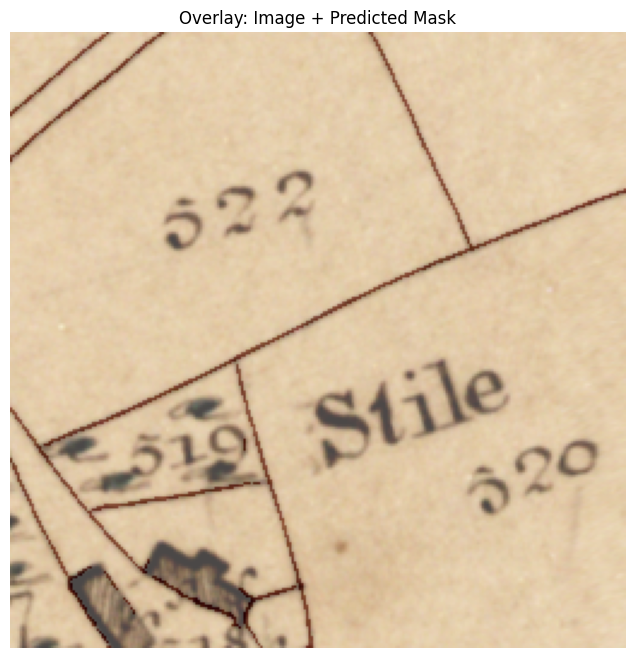

In [12]:
# ==================== PREDICTION & VISUALIZATION ====================

def predict_and_visualize(image_path, model_weights_path='model-T_u-a_d_aspp-maproad.h5'):
    """
    Load a new image, predict its mask, and visualize both side by side
    """
    # Load the trained model
    print("Loading trained model...")
    model = build_attn_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dice_loss)
    model.load_weights(model_weights_path)
    
    # Load and preprocess the new image
    print(f"Loading image: {image_path}")
    img = load_img(image_path, color_mode='rgb')  # RGB for 3-channel input
    original_img = img_to_array(img)  # Keep original for display
    
    # Preprocess for model input
    img_array = img_to_array(img)
    img_array = tf.image.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
    img_array = img_array.numpy() / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    print("Making prediction...")
    prediction = model.predict(img_array, verbose=1)[0]
    
    # Convert prediction to binary mask (0 or 1)
    binary_mask = (prediction > 0.5).astype(np.uint8)
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_img / 255.0)  # Show original image
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Raw prediction (probability map)
    axes[1].imshow(prediction.squeeze(), cmap='viridis')
    axes[1].set_title('Prediction Probability')
    axes[1].axis('off')
    
    # Binary mask
    axes[2].imshow(binary_mask.squeeze(), cmap='gray')
    axes[2].set_title('Binary Mask (Threshold > 0.5)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Also show overlay
    plt.figure(figsize=(10, 8))
    plt.imshow(original_img / 255.0)  # Background
    plt.imshow(binary_mask.squeeze(), alpha=0.3, cmap='Reds')  # Overlay mask
    plt.title('Overlay: Image + Predicted Mask')
    plt.axis('off')
    plt.show()
    
    return prediction, binary_mask

# Additional function to save the predicted mask
def save_predicted_mask(binary_mask, output_path):
    """Save the predicted mask as an image file"""
    from tensorflow.keras.preprocessing.image import save_img
    # Convert to 0-255 range for image saving
    mask_to_save = (binary_mask * 255).astype(np.uint8)
    save_img(output_path, mask_to_save)
    print(f"Mask saved to: {output_path}")

# Additional function for batch prediction on multiple images
def predict_batch(image_paths, model_weights_path='model-T_u-a_d_aspp-maproad.h5'):
    """Predict masks for multiple images"""
    model = build_attn_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dice_loss)
    model.load_weights(model_weights_path)
    
    all_predictions = []
    all_binary_masks = []
    
    for image_path in image_paths:
        print(f"Processing: {image_path}")
        
        # Load and preprocess
        img = load_img(image_path, color_mode='rgb')
        img_array = img_to_array(img)
        img_array = tf.image.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
        img_array = img_array.numpy() / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict
        prediction = model.predict(img_array, verbose=0)[0]
        binary_mask = (prediction > 0.4).astype(np.uint8)
        
        all_predictions.append(prediction)
        all_binary_masks.append(binary_mask)
    
    return all_predictions, all_binary_masks

# ==================== USAGE EXAMPLES ====================

# Example 1: Predict and visualize a single image
image_path = "training_dataset/tithe/test/images/patch_18_21.png"  # Replace with your image path
prediction, binary_mask = predict_and_visualize(image_path)

# Example 2: Save the predicted mask
#save_predicted_mask(binary_mask, 'predicted_mask.png')

# Example 3: Predict multiple images
# image_paths = ['image1.png', 'image2.png', 'image3.png']
# all_predictions, all_masks = predict_batch(image_paths)